In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from scipy import optimize
import seaborn as sns
from scipy import stats
from scipy.stats import yeojohnson
import statsmodels.formula.api as smf

talk = False
online = True
if talk:
    sns.set(context="talk", style="darkgrid")
    figdir = "talk-figures/"
    dpi = 96
else:
    sns.set(context="paper", style="whitegrid")
    matplotlib.rcParams["pdf.fonttype"] = 42
    figdir = "figures/"
    dpi = 140

In [2]:
def linear(x, slope, y_intercept):
    return x * slope + y_intercept


def exponential(X, a, b):
    return a * np.exp(b * X)


def trunc_normal(lower, mean, sigma):
    # upper = 1e6
    a = (lower - mean) / sigma
    # b = (upper - mean) / sigma
    b = np.inf
    X = stats.truncnorm(a, b, loc=mean, scale=sigma)
    return X

# Misstep 1: Applying algebra to random variables

Example: Winland equation

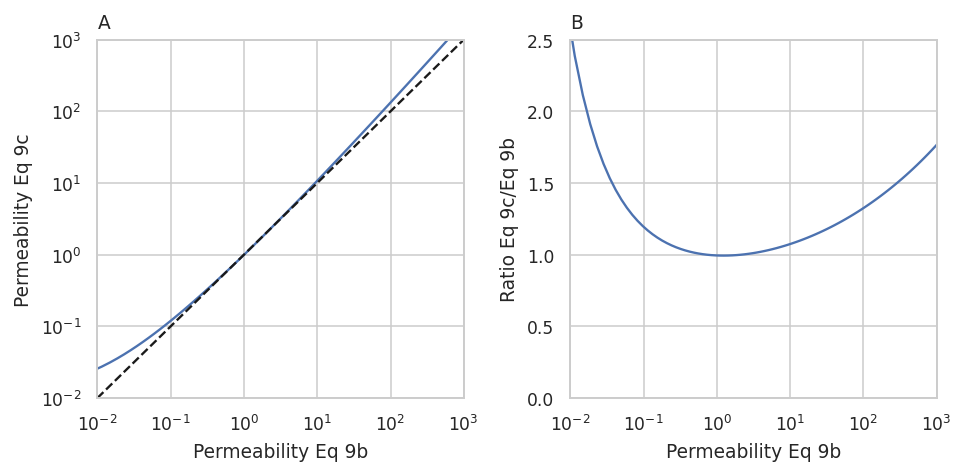

In [3]:
# Figure 3
rng = np.random.default_rng(seed=174)
if talk:
    figsize = (10, 5)
else:
    figsize = (7, 3.5)

# phi = rng.normal(9, 3, 100)
phi = np.linspace(0.5, 33, 100)
permeability = np.power(10, 0.174 * phi - 1.88)
r_p = np.power(10, 0.531 * np.log10(permeability) - 0.350 * np.log10(phi) + 0.204)
permeability_eq9b = np.power(10, 1.512 * np.log10(r_p) + 1.415 * np.log10(phi) - 1.221)
permeability_eq9c = np.power(10, 1.88 * np.log10(r_p) + 0.659 * np.log10(phi) - 0.384)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
ax1.loglog(permeability_eq9b, permeability_eq9c)
ax1.plot([0, 1e3], [0, 1e3], "--k")
ax1.set(
    xlabel="Permeability Eq 9b",
    xlim=(0.01, 1000),
    ylabel="Permeability Eq 9c",
    ylim=(0.01, 1000),
)
ax1.set_title("A", loc="left")

ax2.semilogx(permeability_eq9b, permeability_eq9c / permeability_eq9b)
ax2.set(
    xlabel="Permeability Eq 9b",
    xlim=(0.01, 1000),
    ylabel="Ratio Eq 9c/Eq 9b",
    ylim=(0, 2.5),
)
ax2.set_title("B", loc="left")
plt.tight_layout()

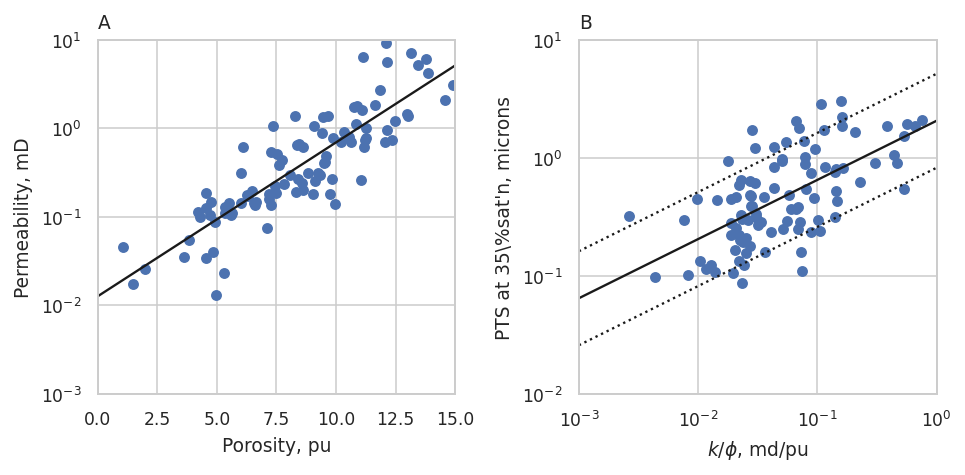

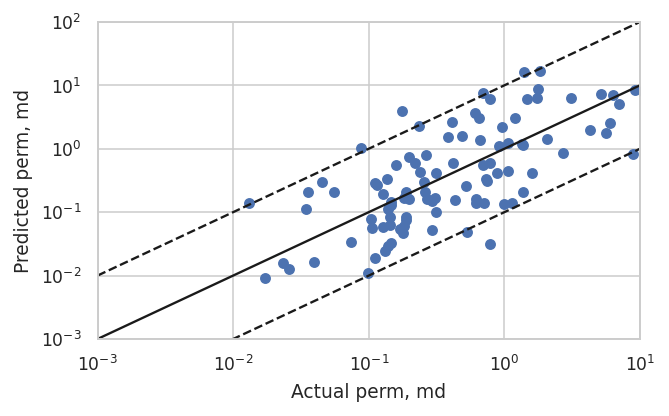

In [4]:
# Figures 4 and 5
if talk:
    figsize = (10, 5)
    figsize2 = (7, 5)
    dpi = 96
else:
    figsize = (7, 3.5)
    figsize2 = (5, 3)
    dpi = 140
rng = np.random.default_rng(seed=174)

porosity = rng.normal(9, 3, 100)
err = rng.normal(0, 0.3, 100)
err2 = rng.normal(0, 0.3, 100)
permeability = np.power(10, 0.174 * porosity - 1.88 + err)
# a, b, c = 0.588, -0.864, 0.732  # Kolodzie
a, b, c, = (
    0.531,
    -0.350,
    0.204,
)  # Pittman
log_pore_throat_size = a * np.log10(permeability) + b * np.log10(porosity) + c + err2
pore_throat_size = np.power(10, log_pore_throat_size)

porosity_line = np.array([0.01, 15])
(slope, y_intercept), _ = optimize.curve_fit(linear, porosity, np.log(permeability))
perm_pred = np.exp(linear(porosity_line, slope, y_intercept))

k_phi_line = np.array([1e-3, 1])
(slope, y_intercept), _ = optimize.curve_fit(
    linear, np.log(permeability / porosity), np.log(pore_throat_size)
)
pts_pred = np.exp(slope * np.log(k_phi_line) + y_intercept)

permeability_predicted = np.power(
    10, 1.88 * np.log10(pore_throat_size) + 0.659 * np.log10(porosity) - 0.384
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
ax1.scatter(porosity, permeability)
ax1.plot(porosity_line, perm_pred, "k-")
ax1.set(
    xlabel="Porosity, pu",
    xlim=(0, 15),
    ylabel="Permeability, mD",
    yscale="log",
    ylim=(0.001, 10),
)
ax1.set_title("A", loc="left")

ax2.scatter(permeability / porosity, pore_throat_size)
ax2.plot(k_phi_line, pts_pred, "-k")
ax2.plot(k_phi_line, pts_pred * 2.5, ":k")
ax2.plot(k_phi_line, pts_pred / 2.5, ":k")
ax2.set(
    xlabel=r"$k/\phi$, md/pu",
    xscale="log",
    xlim=(0.001, 1),
    ylabel="PTS at 35\%sat'n, microns",
    yscale="log",
    ylim=(0.01, 10),
)
ax2.set_title("B", loc="left")
plt.tight_layout()

fig, ax = plt.subplots(figsize=figsize2, dpi=dpi)
ax.scatter(permeability, permeability_predicted)
ax.set(
    xlabel="Actual perm, md",
    xscale="log",
    xlim=(0.001, 10),
    ylabel="Predicted perm, md",
    yscale="log",
    ylim=(0.001, 100),
)
ax.plot([0, 10], [0, 10], color="k")
ax.plot([1e-3, 10], [1e-2, 100], "--k")
ax.plot([1e-3, 10], [1e-4, 1], "--k")

# Misstep 2: De-transforming regression relationships

Text(0.0, 1.0, 'B')

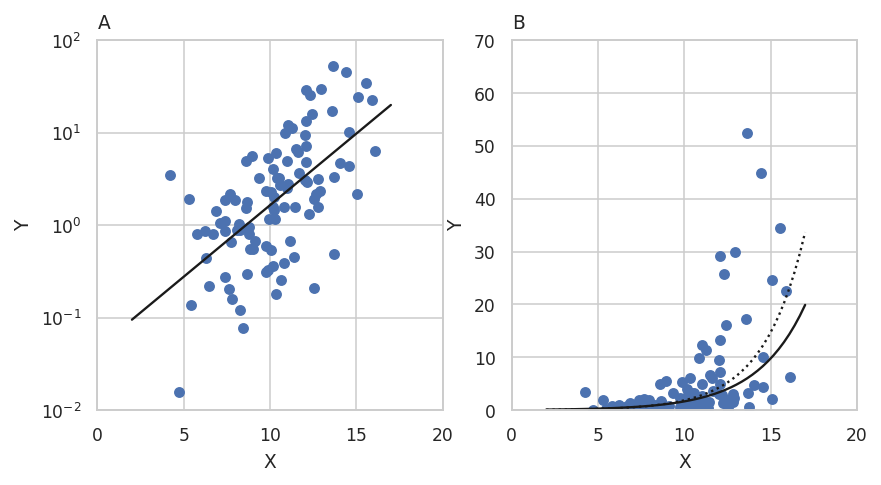

In [5]:
# Figure 6
if talk:
    figsize = (10, 5)
else:
    figsize = (7, 3.5)

rng = np.random.default_rng(seed=99)
X = rng.normal(10, 3, 100)
err = rng.normal(0, 0.5, 100)


def true_fit(X):
    return 1.85 * 10 ** (0.18 * X - 1.8)


Y = np.power(10, np.log10(true_fit(X)) + err)

(slope, intercept), _ = optimize.curve_fit(linear, X, np.log(Y))
X_line = np.linspace(2, 17, 50)
Y_biased = np.exp(slope * X_line + intercept)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
ax1.scatter(X, Y)
ax1.plot(X_line, Y_biased, "k")
ax1.set(xlabel="X", xlim=(0, 20), ylabel="Y", yscale="log", ylim=(0.01, 100))
ax1.set_title("A", loc="left")

ax2.scatter(X, Y)
ax2.set(xlabel="X", xlim=(0, 20), ylabel="Y", ylim=(0, 70))
ax2.plot(X_line, Y_biased, "k")
ax2.plot(X_line, true_fit(X_line), ":k")
ax2.set_title("B", loc="left")

# Misstep 3: Interpreting R-squared incorrectly
## Case A: Arps example

In [6]:
def arps_eq(t: np.ndarray, b: float, D: float):
    q = (1 + err) / (1 + b * D * t) ** (1 / b)
    return q


def exponential_eq(t, q0, tau):
    q = q0 * np.exp(-t / tau)
    return q


def sepd_eq(t, q0, tau, beta):
    q = q0 * np.exp(-(t**beta) / tau)
    return q

correlation coefficient for an exponential fit is 0.952
55.55385068843385 55.180825742949956
Over a 20 year period, the exponential fit would underpredict Arps by 0.67%


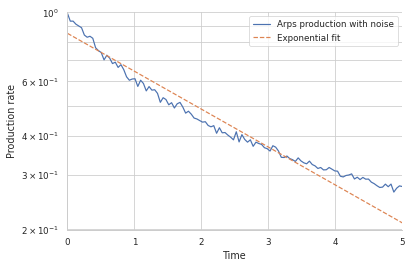

In [7]:
t = np.linspace(0, 5, 120)
b = 1.3
D = 0.7

err_sd = 0.01
np.random.seed(420)
err = np.random.normal(0, err_sd, len(t))
q = arps_eq(t, b, D) * (1 + err)

plt.semilogy(t, q, label="Arps production with noise")
# exponential fit
(q0, tau), _ = optimize.curve_fit(exponential_eq, t, q)
q_exp = exponential_eq(t, q0, tau)
plt.semilogy(t, q_exp, "--", label="Exponential fit")
print(
    f"correlation coefficient for an exponential fit is {np.corrcoef(q, q_exp)[0,1]**2:.3f}"
)

# stretched exponential fit
# (q0, tau, beta), _ = optimize.curve_fit(sepd_eq, t, q)
# q_sepd = sepd_eq(t, q0, tau, beta)
# plt.semilogy(t, q_sepd, '--', label='Stretched Exponential fit')
# print(f"correlation coefficient for SEPD is {np.corrcoef(q, q_sepd)[0,1]**2:.3f}")

sns.despine()
ax = plt.gca()
ax.set(xlabel="Time", xlim=(0, 5), ylabel="Production rate", ylim=(0.2, 1))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.1))
plt.legend(loc="best")
if not online:
    plt.savefig(
        figdir + "Arps_production_fit.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.savefig(
        figdir + "Figure 7 - Arps_production_fit.pdf",
        bbox_inches="tight",
        transparent=True,
    )

t2 = np.linspace(0, 20, 20 * 120)
q2 = arps_eq(t, b, D)
q_exp2 = exponential_eq(t, q0, tau)
print(sum(q2), sum(q_exp2))
print(
    f"Over a 20 year period, the exponential fit would underpredict Arps by {1-sum(q_exp2)/sum(q2):.2%}"
)

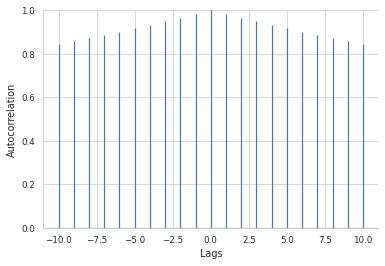

In [8]:
fig, ax = plt.subplots()
lags, c, _, _ = ax.acorr(q)
ax.set(xlabel="Lags", ylabel="Autocorrelation", ylim=(0, 1))
sns.despine()
if not online:
    fig.savefig(figdir + "Arps_autocorrelations.png", dpi=300, bbox_inches="tight")
    # fig.savefig(figdir + "Arps_autocorrelations.pdf", dpi=300, bbox_inches='tight', transparent=True)

In [9]:
df = pd.DataFrame({"t": t, "q": q})

# Use HAC to correct for heteroscedasticity and autocorrelation in regression
# Note: it does not work very well in this case
reg = smf.ols("np.log(q) ~ 1 + t", data=df).fit(cov_type="HAC", cov_kwds={"maxlags": 5})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:              np.log(q)   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     298.4
Date:                Fri, 22 Jul 2022   Prob (F-statistic):           4.23e-34
Time:                        22:02:03   Log-Likelihood:                 134.91
No. Observations:                 120   AIC:                            -265.8
Df Residuals:                     118   BIC:                            -260.2
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2387      0.043     -5.562      0.0

# Case B: multimodal response

The correlation is 0.909


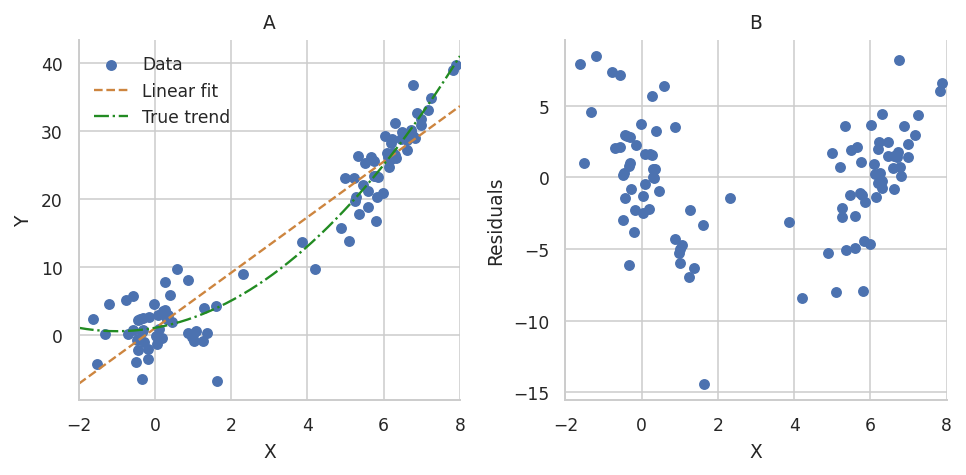

In [10]:
rng = np.random.default_rng(seed=420)

X1 = rng.normal(0, 1, 50)
X2 = rng.normal(6, 1, 50)
X = np.concatenate([X1, X2])
err = rng.normal(0, 3, 100)

Y = 1 + X + 0.5 * X**2 + err


def linear(x, slope, y_intercept):
    return x * slope + y_intercept


if talk:
    figsize = (10, 5)
else:
    figsize = (7, 3.5)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
plt.sca(ax1)
plt.scatter(X, Y, label="Data")

(slope, y_intercept), _ = optimize.curve_fit(linear, X, Y)
Y_pred = linear(X, slope, y_intercept)

resid = Y - Y_pred

X_pred = np.linspace(-2, 8)
Y_pred2 = linear(X_pred, slope, y_intercept)
Y_true = 1 + X_pred + 0.5 * X_pred**2
ax1.plot(X_pred, Y_pred2, "--", label="Linear fit", color="peru")
ax1.plot(X_pred, Y_true, "-.", label="True trend", color="forestgreen")
ax1.set(xlabel="X", ylabel="Y", title="A", xlim=(-2, 8))
ax1.legend(frameon=False)

ax2.scatter(X, resid)
ax2.set(xlabel="X", ylabel="Residuals", title="B", xlim=(-2, 8))

fig.tight_layout()
sns.despine()
if not online:
    fig.savefig(figdir + "Multimodal_inputs.png", dpi=300, bbox_inches="tight")
    fig.savefig(
        figdir + "Figure 8 - Multimodal_inputs.pdf",
        dpi=300,
        bbox_inches="tight",
        transparent=True,
    )

R2 = np.corrcoef(Y, Y_pred)[0, 1] ** 2
print(f"The correlation is {R2:.3f}")

# Case C: Skewed response variable

## Exponential input

The R^2 of this heteroscedastic distribution is 0.718
The R^2 of the power-transformed distribution is 0.894
The lambda that best fits is -0.11
The R^2 of the log-transformed distribution is 0.902
The best fit form is Y = 1.3 * exp(0.91 * X)
The best fit after transform is Y = 0.98 * exp(0.99 * X)


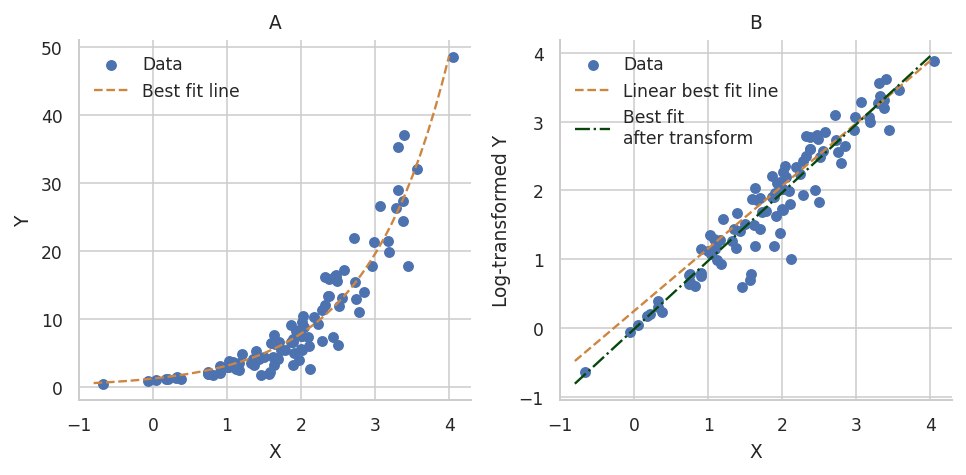

In [11]:
rng = np.random.default_rng(seed=116)

X = rng.normal(2, 1, 100)
err = rng.normal(0, 0.6 * X**2, 100)

Y = np.exp(X) + err
print(
    f"The R^2 of this heteroscedastic distribution is {np.corrcoef(X, Y)[0,1]**2:.3f}"
)

Y_yeo_johnson, lambda1 = yeojohnson(Y)
print(
    f"The R^2 of the power-transformed distribution is {np.corrcoef(X, Y_yeo_johnson)[0,1]**2:.3f}"
)
Y_log = np.log(Y)
print(f"The lambda that best fits is {lambda1:.2f}")
print(
    f"The R^2 of the log-transformed distribution is {np.corrcoef(X, Y_log)[0,1]**2:.3f}"
)


def linear(x, slope, y_intercept):
    return x * slope + y_intercept


(a, b), _ = optimize.curve_fit(exponential, X, Y)
# (a_yj, b_yj), _ = optimize.curve_fit(linear, X, Y_yeo_johnson)

(a_transformed, b_transformed), _ = optimize.curve_fit(linear, X, Y_log)
print(f"The best fit form is Y = {a:.2} * exp({b:.2} * X)")
print(
    f"The best fit after transform is Y = {np.exp(b_transformed):.2} * exp({a_transformed:.2} * X)"
)

X_pred = np.linspace(-0.8, 4)
Y_pred = exponential(X_pred, a, b)
Y_pred_log = linear(X_pred, a_transformed, b_transformed)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
ax1.scatter(X, Y, label="Data")
ax1.plot(X_pred, Y_pred, "--", color="peru", label="Best fit line")
ax1.legend(loc="best", frameon=False)
ax1.set(xlabel="X", ylabel="Y", title="A", xlim=(-1, None))

ax2.scatter(X, Y_log, label="Data")
ax2.plot(X_pred, np.log(Y_pred), "--", color="peru", label="Linear best fit line")
ax2.plot(
    X_pred,
    Y_pred_log,
    "-.",
    color=sns.xkcd_rgb["forest green"],
    label="Best fit\nafter transform",
)
ax2.set(xlabel="X", ylabel="Log-transformed Y", title="B", xlim=(-1, None))
ax2.legend(loc="upper left", frameon=False)

sns.despine()
plt.tight_layout()
if not online:
    fig.savefig(figdir + "exponential_input.png", dpi=300, bbox_inches="tight")
    fig.savefig(
        figdir + "Figure 9 - exponential_input.pdf",
        dpi=300,
        bbox_inches="tight",
        transparent=True,
    )

## Censored distribution

The R^2 for the non-censored case would be 0.820
The R^2 for the censored case is 0.783
The slope and y_intercept of the fits are slope=0.91 and y_intercept=0.17


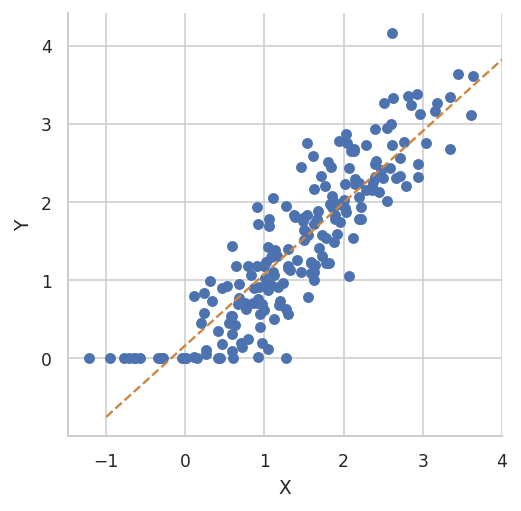

In [12]:
rng = np.random.default_rng(seed=96)

X = rng.normal(1.5, 1, 200)
err = rng.normal(0, 0.5, 200)

Y = X + err
print(f"The R^2 for the non-censored case would be {np.corrcoef(X, Y)[0,1]**2:.3f}")
Y[Y < 0] = 0
print(f"The R^2 for the censored case is {np.corrcoef(X, Y)[0,1]**2:.3f}")


def linear(x, slope, y_intercept):
    return x * slope + y_intercept


(slope, y_intercept), _ = optimize.curve_fit(linear, X, Y)
Y_pred = linear(X, slope, y_intercept)
# resid = Y - Y_pred
X_pred = np.linspace(-1, 4)
Y_pred2 = linear(X_pred, slope, y_intercept)

print(
    f"The slope and y_intercept of the fits are slope={slope:.2f} and y_intercept={y_intercept:.2f}"
)
fig, ax = plt.subplots(figsize=(4, 4), dpi=dpi)
ax.scatter(X, Y, label="Data")
ax.plot(X_pred, Y_pred2, "--", color="peru", label="Fit")
ax.grid(True)
ax.set(xlabel="X", ylabel="Y", xlim=(None, 4))
sns.despine()
if not online:
    plt.savefig(figdir + "Censored.png", dpi=300, bbox_inches="tight")
    plt.savefig(
        figdir + "Figure 10 - Censored.pdf",
        dpi=300,
        bbox_inches="tight",
        transparent=True,
    )